In [1]:
import numpy as np
from sklearn.cluster import k_means

def bkmeans(X:np.ndarray, k:int, i:int) -> np.ndarray:
    """Bisecting k-Means"""
    res = np.zeros(X.shape[0], dtype=int)
    for kk in range(1, k):
        values, counts = np.unique(res, return_counts=True)
        most_common_k = values[counts.argmax()]
        most_common_indices = res == most_common_k
        new_clusters = k_means(X[most_common_indices], 2, n_init=i)[1]
        res[most_common_indices] = np.where(new_clusters == 0, most_common_k, kk)
    return res

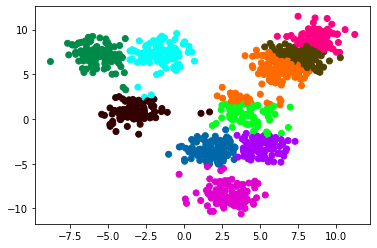

In [2]:
from colormap import generate_colormap
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt

X, y = make_blobs(n_samples=1000, centers=10, n_features=2)
k = 10
c = bkmeans(X, k, 100)

plt.figure()
plt.scatter(X[:, 0], X[:, 1], c=c, cmap=generate_colormap(k))
plt.show()